# 1. 📦 INSTALLS & IMPORTS

In [53]:
pip install neurokit2

Note: you may need to restart the kernel to use updated packages.


In [54]:
pip install entropy

Note: you may need to restart the kernel to use updated packages.


In [55]:
# Standard libraries
import os
from collections import Counter

# Data processing and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ECG processing
import neurokit2 as nk

# Progress tracking
from tqdm import tqdm

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, ConfusionMatrixDisplay,
                           roc_auc_score, roc_curve, auc)

# Serialization
import pickle

# 2. WESAD Dataset Loader and ECG Preprocessor

In [56]:


base_path = "/kaggle/input/wesad-full-dataset/WESAD/"
subject_ids = [f"S{i}" for i in range(2, 18)]  # S2 to S17
all_subjects_dfs = []

for subject_id in subject_ids:
    txt_file = f"{base_path}{subject_id}/{subject_id}_respiban.txt"
    pkl_file = f"{base_path}{subject_id}/{subject_id}.pkl"
    
    if not os.path.exists(txt_file) or not os.path.exists(pkl_file):
        print(f"Skipping {subject_id} - files not found")
        continue
    
    try:
        # Load ECG
        ecg_data = np.loadtxt(txt_file)
        ecg_raw = ecg_data[:, 2]  # Column 2 = ECG
        
        # Load labels
        with open(pkl_file, "rb") as f:
            labels = pickle.load(f, encoding="latin1")["label"]
        
        # Ensure equal lengths
        min_length = min(len(ecg_raw), len(labels))
        ecg_raw = ecg_raw[:min_length]
        labels = labels[:min_length]
        
        # Convert to mV
        ecg_mv = ((ecg_raw / 65536) - 0.5) * 3.0
        
        # Create DataFrame
        df = pd.DataFrame({
            "timestamp": np.arange(min_length) / 700,
            "ecg_mv": ecg_mv,
            "label": labels,
            "subject_id": subject_id
        })
        all_subjects_dfs.append(df)
        print(f"Processed {subject_id} | ECG: {len(ecg_raw)} | Labels: {len(labels)}")
        
    except Exception as e:
        print(f"Error processing {subject_id}: {str(e)}")

if all_subjects_dfs:
    combined_df = pd.concat(all_subjects_dfs, ignore_index=True)
    print(f"\nSuccess! Combined DataFrame shape: {combined_df.shape}")
    print("Label distribution:")
    print(combined_df["label"].value_counts())
else:
    print("\nNo valid data processed.")

Processed S2 | ECG: 4255300 | Labels: 4255300
Processed S3 | ECG: 4545100 | Labels: 4545100
Processed S4 | ECG: 4496100 | Labels: 4496100
Processed S5 | ECG: 4380600 | Labels: 4380600
Processed S6 | ECG: 4949700 | Labels: 4949700
Processed S7 | ECG: 3666600 | Labels: 3666600
Processed S8 | ECG: 3826200 | Labels: 3826200
Processed S9 | ECG: 3656100 | Labels: 3656100
Processed S10 | ECG: 3847200 | Labels: 3847200
Processed S11 | ECG: 3663100 | Labels: 3663100
Skipping S12 - files not found
Processed S13 | ECG: 3875900 | Labels: 3875900
Processed S14 | ECG: 3883600 | Labels: 3883600
Processed S15 | ECG: 3676400 | Labels: 3676400
Processed S16 | ECG: 3941700 | Labels: 3941700
Processed S17 | ECG: 4144000 | Labels: 4144000

Success! Combined DataFrame shape: (60807600, 4)
Label distribution:
label
0    27654897
1    12327702
4     8264199
2     6976201
3     3902501
7      576802
6      552998
5      552300
Name: count, dtype: int64


# 4. Filter & Map to Binary Stress Label

In [57]:

# Assuming combined_df is already loaded
valid_df = combined_df[combined_df["label"].isin([1, 2, 3])].copy()
valid_df["binary_label"] = np.where(valid_df["label"] == 2, 1, 0)

# Get the counts
binary_counts = valid_df["binary_label"].value_counts().sort_index()

# Format the output
output = f"Binary Label Distribution:\n" + \
         f"0    {binary_counts[0]:>8}  # Non-stress (baseline + amusement)\n" + \
         f"1    {binary_counts[1]:>8}  # Stress\n" + \
         f"Name: binary_label, dtype: int64"

print(output)

Binary Label Distribution:
0    16230203  # Non-stress (baseline + amusement)
1     6976201  # Stress
Name: binary_label, dtype: int64


# 5. Visualize Class Distribution

Sample Data:
        timestamp  ecg_mv  label subject_id  binary_label
214583    306.547  -0.049      1         S2             0
214584    306.549  -0.055      1         S2             0
214585    306.550  -0.056      1         S2             0
214586    306.551  -0.059      1         S2             0
214587    306.553  -0.066      1         S2             0


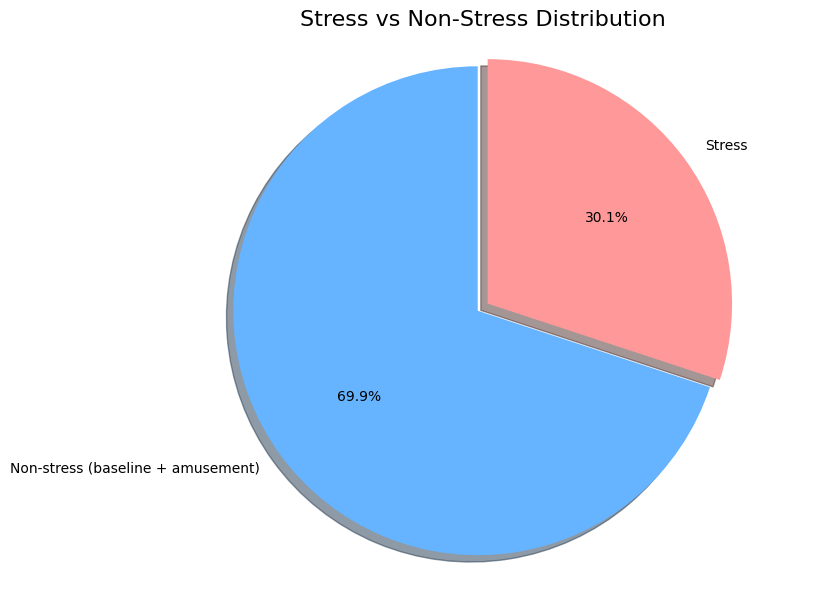

In [58]:


# 1. Display the first 5 rows of the DataFrame
print("Sample Data:")
print(valid_df.head())

# 2. Create the pie chart
plt.figure(figsize=(8, 6))


# Define labels and colors
labels = ['Non-stress (baseline + amusement)', 'Stress']
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)  # Explode the 1st slice

plt.pie(binary_counts, 
        labels=labels, 
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=explode,
        shadow=True)

plt.title('Stress vs Non-Stress Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as circle
plt.tight_layout()
plt.show()

# 6. Data segmentation functions to make windowes


                WINDOW STATISTICS                 

Total windows created: 1,061

Label distribution:
Non-stress (0): 746 windows (70.3%)
Stress (1):     315 windows (29.7%)

Class ratio: 2.37:1 (Non-stress:Stress)


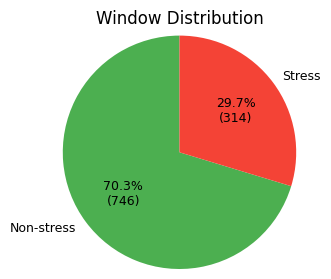

In [59]:



def create_labeled_windows(df, window_sec=60, sample_rate=700, min_agreement=0.75, overlap=0.5):
    """
    Create labeled ECG windows from continuous data with overlap.
    
    Parameters:
        df: Input DataFrame with ECG data and labels
        window_sec: Window length in seconds
        sample_rate: Sampling rate in Hz
        min_agreement: Minimum agreement threshold for label assignment
        overlap: Fractional overlap between windows (e.g., 0.5 = 50%)
        
    Returns:
        windows: ECG signal windows
        labels: Corresponding labels
    """
    window_size = window_sec * sample_rate
    step_size = int(window_size * (1 - overlap))
    
    windows = []
    labels = []
    
    for subject, subject_df in df.groupby('subject_id'):
        ecg_signal = subject_df['ecg_mv'].values
        binary_labels = subject_df['binary_label'].values
        
        for start in range(0, len(subject_df) - window_size + 1, step_size):
            end = start + window_size
            window_labels = binary_labels[start:end]
            
            label_counts = Counter(window_labels)
            majority_label, majority_count = label_counts.most_common(1)[0]
            agreement = majority_count / window_size
            
            if agreement >= min_agreement:
                windows.append(ecg_signal[start:end])
                labels.append(majority_label)
    
    return np.array(windows), np.array(labels)

# Create windows with 50% overlap
windows, labels = create_labeled_windows(valid_df, overlap=0.5)

# Calculate statistics
total_windows = len(windows)
label_counts = pd.Series(labels).value_counts().sort_index()
label_percent = label_counts / total_windows * 100

# Text Output
print(f"\n{'='*50}")
print(f"{'WINDOW STATISTICS':^50}")
print(f"{'='*50}")
print(f"\nTotal windows created: {total_windows:,}")
print("\nLabel distribution:")
print(f"Non-stress (0): {label_counts.get(0, 0):,} windows ({label_percent.get(0, 0):.1f}%)")
print(f"Stress (1):     {label_counts.get(1, 0):,} windows ({label_percent.get(1, 0):.1f}%)")
print(f"\nClass ratio: {label_counts.get(0, 1)/label_counts.get(1, 1):.2f}:1 (Non-stress:Stress)")

# Pie Chart
plt.subplot(1, 3, 1)
plt.pie(label_counts, 
        labels=['Non-stress', 'Stress'],
        colors=['#4CAF50', '#F44336'],
        radius=2,
        autopct=lambda p: f'{p:.1f}%\n({int(p/100*total_windows):,})',
        startangle=90,
        textprops={'fontsize': 9})
plt.title('Window Distribution', pad=40)

plt.show()


# 7. Extracting Features

In [60]:


def calculate_hr(peaks, sampling_rate):
    """Robust heart rate calculation"""
    if len(peaks['ECG_R_Peaks']) < 2:
        return np.nan
    rr_intervals = np.diff(peaks['ECG_R_Peaks']) / sampling_rate
    return float(60 / np.mean(rr_intervals))

def extract_ecg_features(ecg_signal, sampling_rate=700):
    """Optimized feature extraction with guaranteed numeric output"""
    try:
        # 1. Preprocessing
        cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)
        
        # 2. Peak detection
        peaks = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate, method="kalidas2017")[1]
        
        # 3. Feature extraction
        features = {
            # Basic ECG stats (always available)
            'ecg_mean': float(np.mean(cleaned)),
            'ecg_std': float(np.std(cleaned)),
            'ecg_skew': float(pd.Series(cleaned).skew()),
            'ecg_kurtosis': float(pd.Series(cleaned).kurtosis()),
            
            # Heart rate (fixed calculation)
            'hr_mean': calculate_hr(peaks, sampling_rate),
        }
        
        # 4. HRV features (only if enough peaks)
        if len(peaks['ECG_R_Peaks']) > 4:
            hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate)
            hrv_freq = nk.hrv_frequency(peaks, sampling_rate=sampling_rate)
            
            features.update({
                'hrv_sdnn': float(hrv_time['HRV_SDNN'].iloc[0]),
                'hrv_rmssd': float(hrv_time['HRV_RMSSD'].iloc[0]),
                'hrv_pnn50': float(hrv_time['HRV_pNN50'].iloc[0]),
                'hrv_hf': float(hrv_freq['HRV_HF'].iloc[0]),
                'hrv_lf': float(hrv_freq['HRV_LF'].iloc[0]),
                'hrv_lfhf': float(hrv_freq['HRV_LFHF'].iloc[0])
            })
        
        return features
        
    except Exception as e:
        print(f"Error in feature extraction: {str(e)}")
        return None

def process_all_windows(windows, labels, sampling_rate=700):
    """
    Process all ECG windows and create feature matrix
    
    Parameters:
        windows (list): List of ECG window arrays
        labels (array): Corresponding labels
        sampling_rate (int): Sampling frequency in Hz
        
    Returns:
        DataFrame: Features with labels
    """
    features = []
    for i in tqdm(range(len(windows)), desc="Extracting Features"):
        feat = extract_ecg_features(windows[i], sampling_rate)
        if feat is not None:  # Only append if feature extraction succeeded
            feat['label'] = labels[i]
            features.append(feat)
    
    return pd.DataFrame(features).fillna(method='ffill')

# Example usage (assuming you have windows and labels defined)
if __name__ == "__main__":
    # You'll need to define these variables first:
    # windows = [your_ecg_data_arrays]
    # labels = [corresponding_labels]
    
    feature_df = process_all_windows(windows, labels)

    # Display final results
    print("\n" + "="*50)
    print(f"{'FINAL FEATURE EXTRACTION RESULTS':^50}")
    print("="*50)
    print(f"\nTotal windows processed: {len(feature_df)}")
    print(f"Success rate: {100*(1-feature_df.isna().mean().mean()):.1f}%")
    print("\nLabel distribution:")
    print(feature_df['label'].value_counts())
    print("\nFeature preview (no NaN values):")
    print(feature_df.dropna().head(3).to_string(float_format="%.3f"))

Extracting Features: 100%|██████████| 1061/1061 [00:26<00:00, 40.71it/s]


         FINAL FEATURE EXTRACTION RESULTS         

Total windows processed: 1061
Success rate: 100.0%

Label distribution:
label
0    746
1    315
Name: count, dtype: int64

Feature preview (no NaN values):
   ecg_mean  ecg_std  ecg_skew  ecg_kurtosis  hr_mean  hrv_sdnn  hrv_rmssd  hrv_pnn50  hrv_hf  hrv_lf  hrv_lfhf  label
0    -0.000    0.126    -0.382         2.999   95.238    50.507     25.941      4.301   0.009   0.041     4.409      0
1    -0.000    0.124    -0.584         1.636   97.363    34.955     12.065      0.000   0.006   0.008     1.351      0
2     0.001    0.113    -0.884         2.722   90.051    51.539     24.597      3.371   0.012   0.015     1.265      0



<ipython-input-60-1e8bc77d1a44>:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(features).fillna(method='ffill')


# 8. New Dataframe after Extracting Features

In [61]:

# Display first 5 rows with formatted floats
pd.set_option('display.float_format', '{:.3f}'.format)
display(feature_df.head().style.set_caption("First 5 Windows with Extracted Features"))

,ecg_mean,ecg_std,ecg_skew,ecg_kurtosis,hr_mean,hrv_sdnn,hrv_rmssd,hrv_pnn50,hrv_hf,hrv_lf,hrv_lfhf,label
0,-0.000123,0.125950,-0.381739,2.999495,95.238095,50.506749,25.941029,4.301075,0.009357,0.041259,4.409306,0
1,-0.000058,0.123550,-0.584029,1.636480,97.363083,34.954781,12.064987,0.000000,0.005561,0.007513,1.351011,0
2,0.000916,0.113400,-0.884450,2.721702,90.050590,51.538806,24.597408,3.370787,0.011746,0.014863,1.265335,0
3,-0.000348,0.104342,-1.007657,1.812786,89.798100,46.630770,15.497838,1.136364,0.005688,0.009197,1.617007,0
4,-0.000061,0.115715,-0.579731,0.732762,95.477630,29.837883,10.275981,0.000000,0.003277,0.008087,2.467865,0


# 9. Feature-Label Correlation Analysis first step in feature selection

In [62]:
correlation_matrix = feature_df.corr()
label_correlation = correlation_matrix['label'].abs().sort_values(ascending=False)
print(label_correlation)

label          1.000
hr_mean        0.647
ecg_kurtosis   0.423
hrv_pnn50      0.315
ecg_std        0.291
ecg_skew       0.251
hrv_rmssd      0.160
hrv_sdnn       0.157
hrv_hf         0.087
hrv_lfhf       0.078
hrv_lf         0.014
ecg_mean       0.004
Name: label, dtype: float64


# 10. Feature selection using correlation threshold

In [63]:
# Automatically drop features with correlation < threshold
low_corr_threshold = 0.1
low_corr_features = label_correlation[label_correlation < low_corr_threshold].index.tolist()
feature_df_optimized = feature_df.drop(columns=low_corr_features)
# Display first 5 rows with formatted floats
pd.set_option('display.float_format', '{:.3f}'.format)
display(feature_df_optimized.head().style.set_caption("First 5 Windows with Extracted Features"))

,ecg_std,ecg_skew,ecg_kurtosis,hr_mean,hrv_sdnn,hrv_rmssd,hrv_pnn50,label
0,0.125950,-0.381739,2.999495,95.238095,50.506749,25.941029,4.301075,0
1,0.123550,-0.584029,1.636480,97.363083,34.954781,12.064987,0.000000,0
2,0.113400,-0.884450,2.721702,90.050590,51.538806,24.597408,3.370787,0
3,0.104342,-1.007657,1.812786,89.798100,46.630770,15.497838,1.136364,0
4,0.115715,-0.579731,0.732762,95.477630,29.837883,10.275981,0.000000,0


# 11. Train/Test Split of data

In [72]:

from sklearn.model_selection import train_test_split

# Standard stratified split (single line)
X_train, X_test, y_train, y_test = train_test_split(
    feature_df_optimized.drop(columns=['label']),
    feature_df_optimized['label'],
    test_size=0.3,
    random_state=42,
    stratify=feature_df_optimized['label']  # Automatic balancing
)

# 12. Apply SMOTE to balnce data 

In [73]:


# Apply SMOTE with 1:1 ratio
smote = SMOTE(
    sampling_strategy=1.0,  # Force exact balance (263:263)
    k_neighbors=5,          # Optimal for ECG feature space
    random_state=42
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verify
print("\nAfter SMOTE:")
print(pd.Series(y_train_smote).value_counts())
print(f"New ratio: {y_train_smote.mean():.1%}")


After SMOTE:
label
0    522
1    522
Name: count, dtype: int64
New ratio: 50.0%


# 13. 📊 Model Comparison Pipeline
# Tests multiple classifiers to identify the best performing model

Model Accuracy: 95.61%

Detailed Report:
              precision    recall  f1-score   support

  Non-stress       0.97      0.97      0.97       224
      Stress       0.93      0.93      0.93        95

    accuracy                           0.96       319
   macro avg       0.95      0.95      0.95       319
weighted avg       0.96      0.96      0.96       319



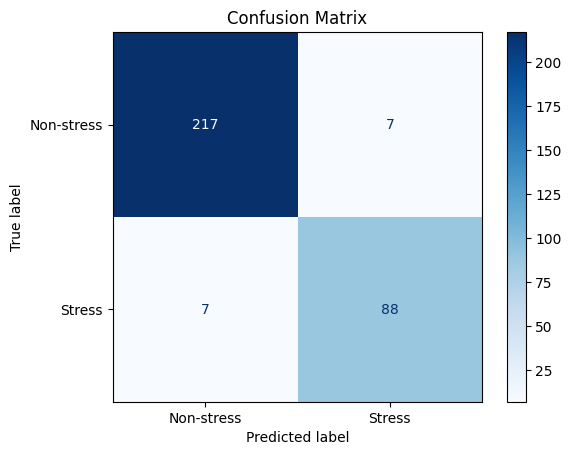

In [84]:

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=11,
 
    random_state=42
)
model.fit(X_train_smote, y_train_smote)
#model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred, target_names=["Non-stress", "Stress"]))

# 3. Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                      display_labels=["Non-stress", "Stress"],
                                      cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [77]:

# Fit scaler ONLY on training data
scaler = RobustScaler().fit(X_train)  # Use SMOTE-augmented data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Transform test set with same scaler

# Verify no data leakage
print(f"Test set scaled (sample):\n{X_test_scaled[0,:5].round(2)}")

Test set scaled (sample):
[-0.18  0.69  0.99 -0.56 -0.15]


In [78]:

# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', C=36, gamma='scale', probability=True, random_state=42)  # Adjust C, gamma if needed
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Model Accuracy: {accuracy_svm:.2%}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=["Non-stress", "Stress"]))

# Calculate AUC
roc_auc_svm = roc_auc_score(y_test, svm_model.predict_proba(X_test_scaled)[:, 1])
print(f"AUC: {roc_auc_svm:.2%}")


SVM Model Accuracy: 96.55%

Detailed Classification Report:
              precision    recall  f1-score   support

  Non-stress       0.96      1.00      0.98       224
      Stress       0.99      0.89      0.94        95

    accuracy                           0.97       319
   macro avg       0.97      0.95      0.96       319
weighted avg       0.97      0.97      0.96       319

AUC: 98.99%


XGBoost Model Accuracy: 94.67%

Detailed Classification Report:
              precision    recall  f1-score   support

  Non-stress       0.96      0.96      0.96       224
      Stress       0.91      0.91      0.91        95

    accuracy                           0.95       319
   macro avg       0.94      0.93      0.94       319
weighted avg       0.95      0.95      0.95       319



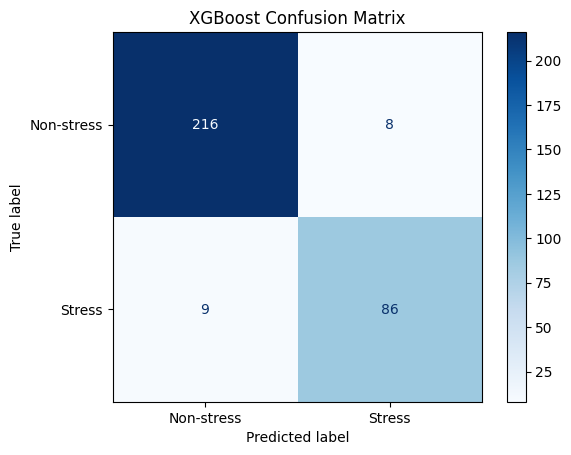

In [89]:


# 1. Initialize and train XGBoost with balanced classes
xgb_model = XGBClassifier(
    max_depth=5,               # Control tree depth
    learning_rate=0.1,         # Shrinkage to prevent overfitting
    n_estimators=300,          # Number of boosting rounds
    scale_pos_weight=2.375,    # Counter class imbalance (48 stress / 114 non-stress ≈ 2.375)
    objective='binary:logistic',
    eval_metric='logloss',     # Alternative: 'auc'
    random_state=42
)

# Train the model with SMOTE-augmented data
xgb_model.fit(X_train_smote, y_train_smote)

# 2. Evaluate the model
y_pred_xgb = xgb_model.predict(X_test)

# Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {accuracy_xgb:.2%}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=["Non-stress", "Stress"]))

# 3. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, 
                                         display_labels=["Non-stress", "Stress"],
                                         cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()



Decision Tree Accuracy: 90.28%

Detailed Report:
              precision    recall  f1-score   support

  Non-stress       0.96      0.90      0.93       224
      Stress       0.79      0.92      0.85        95

    accuracy                           0.90       319
   macro avg       0.88      0.91      0.89       319
weighted avg       0.91      0.90      0.90       319



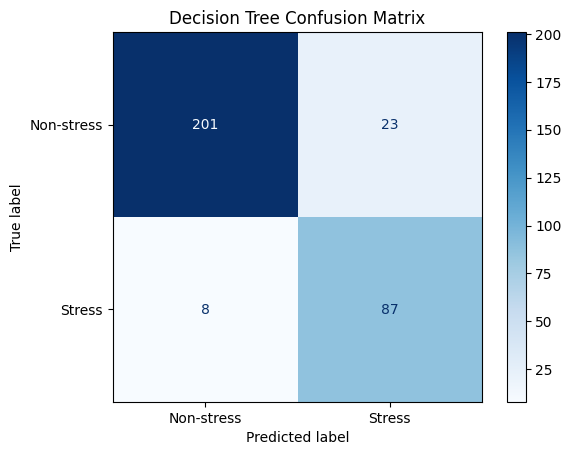

In [91]:

# 1. Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=20,                
    criterion='entropy',        # Use entropy for information gain
    random_state=42
)
dt_model.fit(X_train_smote, y_train_smote)
# 2. Evaluate
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Decision Tree Accuracy: {accuracy:.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred, target_names=["Non-stress", "Stress"]))

# 3. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Non-stress", "Stress"],
    cmap='Blues'
)
plt.title("Decision Tree Confusion Matrix")
plt.show()

# 14. ROC curve to show how good model to discriminate between two clases

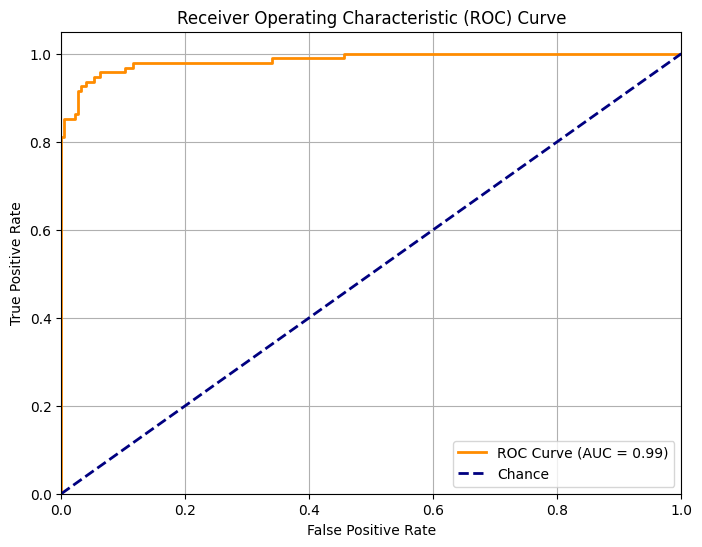

In [79]:


# 1. Predict probabilities for the positive class (Stress = 1)
y_proba = model.predict_proba(X_test)[:, 1]

# 2. Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 3. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
